In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns




In [2]:
def get_data(data_path):
    '''returns a DataFrame with search tracks'''
    data = pd.read_json(data_path)
    data = pd.DataFrame.from_dict(data['__collections__']["search_track"])
    return data


def preprocess_data(data):
    data = data.T
    data = data.drop(columns = ['user_longitude', 'user_latitude', '__collections__'])
    data.reset_index(level=0, inplace=True)
    data.drop(columns="index")
    data['search_method'] = data['search_method'].convert_dtypes()
    
#     data = data[data.search_method == 'update_time_home']
    
    data.drop(columns='index', inplace=True)
    data['timestamp'] = pd.to_datetime(data['timestamp'], utc=True, errors='coerce')
    data['arrive'] = pd.to_datetime(data['arrive'], utc=True, errors='coerce')
    data['leave'] = pd.to_datetime(data['leave'], utc=True, errors='coerce')
    data['timestamp'] = data.timestamp.dt.strftime("%Y-%m-%d %H:%M:%S")
    data['arrive'] = data.arrive.dt.strftime("%Y-%m-%d %H:%M:%S")
    data['leave'] = data.leave.dt.strftime("%Y-%m-%d %H:%M:%S")
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['arrive'] = pd.to_datetime(data['arrive'])
    data['leave'] = pd.to_datetime(data['leave'])

    return data

def preproc(data_path):
    data = get_data(data_path)
    return preprocess_data(data)



In [3]:
data = preproc('../raw_data/dataBackup.json')
data.head(2)

,search_longitude,search_latitude,timestamp,leave,arrive,search_method,uid
0,-58.404267,-34.614640,2021-03-28 16:30:39,2021-03-28 17:30:13,2021-03-28 16:30:13,google,unauthenticated
1,-58.419543,-34.575729,2021-02-04 15:56:36,2021-02-04 17:00:36,2021-02-04 16:00:36,startup,unauthenticated


In [4]:
data["search_hour"] = data["timestamp"].dt.hour
data["arrive_hour"] = data["arrive"].dt.hour
data["leave_hour"] = data["leave"].dt.hour



In [5]:
data


,search_longitude,search_latitude,timestamp,leave,arrive,search_method,uid,search_hour,arrive_hour,leave_hour
0,-58.404267,-34.614640,2021-03-28 16:30:39,2021-03-28 17:30:13,2021-03-28 16:30:13,google,unauthenticated,16.0,16,17
1,-58.419543,-34.575729,2021-02-04 15:56:36,2021-02-04 17:00:36,2021-02-04 16:00:36,startup,unauthenticated,15.0,16,17
2,-58.414274,-34.581036,2021-01-12 10:28:04,2021-01-12 11:30:04,2021-01-12 10:30:04,startup,unauthenticated,10.0,10,11
3,-58.433503,-34.577048,2021-02-05 08:19:35,2021-02-05 09:30:35,2021-02-05 08:30:35,startup,unauthenticated,8.0,8,9
4,-58.440447,-34.620694,2021-01-31 22:35:42,2021-02-28 17:32:00,2021-02-28 15:56:00,google,None,22.0,15,17
...,...,...,...,...,...,...,...,...,...,...
21129,-58.507150,-34.575842,2020-09-14 06:35:26,2020-09-14 07:45:26,2020-09-14 06:45:26,startup,unauthenticated,6.0,6,7
21130,-58.383415,-34.591915,2021-01-23 04:12:43,2021-01-23 05:15:18,2021-01-23 04:15:18,this_area,unauthenticated,4.0,4,5
21131,-58.413258,-34.584307,2021-01-06 02:05:01,2021-01-06 03:15:01,2021-01-06 02:15:01,startup,unauthenticated,2.0,2,3
21132,-58.425847,-34.631331,2021-03-21 19:45:08,2021-03-21 20:45:07,2021-03-21 19:45:07,searchInThisArea,byadzYTQX7YaABRFTAXPYz8UKCI2,19.0,19,20


In [6]:

data['stay_time'] = (data["leave_hour"] - data['arrive_hour']).astype('timedelta64[h]')
data["arrive_weekday"] = data["arrive"].dt.weekday
data.head(2)

,search_longitude,search_latitude,timestamp,leave,arrive,search_method,uid,search_hour,arrive_hour,leave_hour,stay_time,arrive_weekday
0,-58.404267,-34.614640,2021-03-28 16:30:39,2021-03-28 17:30:13,2021-03-28 16:30:13,google,unauthenticated,16.0,16,17,0 days 01:00:00,6
1,-58.419543,-34.575729,2021-02-04 15:56:36,2021-02-04 17:00:36,2021-02-04 16:00:36,startup,unauthenticated,15.0,16,17,0 days 01:00:00,3


In [7]:
def search_neighborhood(neighborhood, coordinates):

    bsas_map = gpd.read_file('../gopa_data/barrios-ciudad')
    bsas_map.BARRIO[6] = 'DIQUE 3'
    bsas_map.BARRIO[24] = 'NUÑEZ'
    bsas_map.BARRIO[26] = 'DIQUE 2'
    bsas_map.BARRIO[33] = 'DIQUE 4'
    bsas_map.BARRIO[35] = 'DIQUE 1'  
    neighborhood = neighborhood.upper()
    gpd_data = gpd.GeoDataFrame(coordinates,
                         geometry = gpd.points_from_xy(coordinates.search_longitude, coordinates.search_latitude))
    reservas_bsas = gpd_data[['geometry']]
    reservas_bsas = reservas_bsas.set_crs("EPSG:4326")

    if neighborhood == 'CIUDAD':
        df_barrio = bsas_map
        fig,ax = plt.subplots(figsize = (15,16))
        bsas_map.plot(ax=ax, color='lightgrey')
        gpd_data.plot(ax=ax, markersize=5, color='red')
        ax.set_xlim([-58.550, -58.325])
        ax.set_ylim([-34.700, -34.525])
        plt.show()

    else:

        try:
            df_barrio = bsas_map[bsas_map['BARRIO'] == neighborhood]
            reservas_barrio = reservas_bsas.within(df_barrio)
            cond_reservas_barrio = gpd_data.apply(lambda x: df_barrio.contains(x.geometry), axis=1)
            gpd_data['reservas_barrio'] = cond_reservas_barrio
            gpd_data = gpd_data[gpd_data.reservas_barrio == True]
            fig,ax = plt.subplots(figsize = (15,16))
            bsas_map.plot(ax=ax, color='lightgrey')
            gpd_data.plot(ax=ax, markersize=5, color='red')
            ax.set_xlim([-58.550, -58.325])
            ax.set_ylim([-34.700, -34.525])
            plt.show()
        except ValueError:
            print("Please enter another neighborhood")


    return gpd_data

<ipython-input-7-b72c0da81043>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bsas_map.BARRIO[6] = 'DIQUE 3'
<ipython-input-7-b72c0da81043>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bsas_map.BARRIO[24] = 'NUÑEZ'
<ipython-input-7-b72c0da81043>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bsas_map.BARRIO[26] = 'DIQUE 2'
<ipython-input-7-b72c0da81043>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

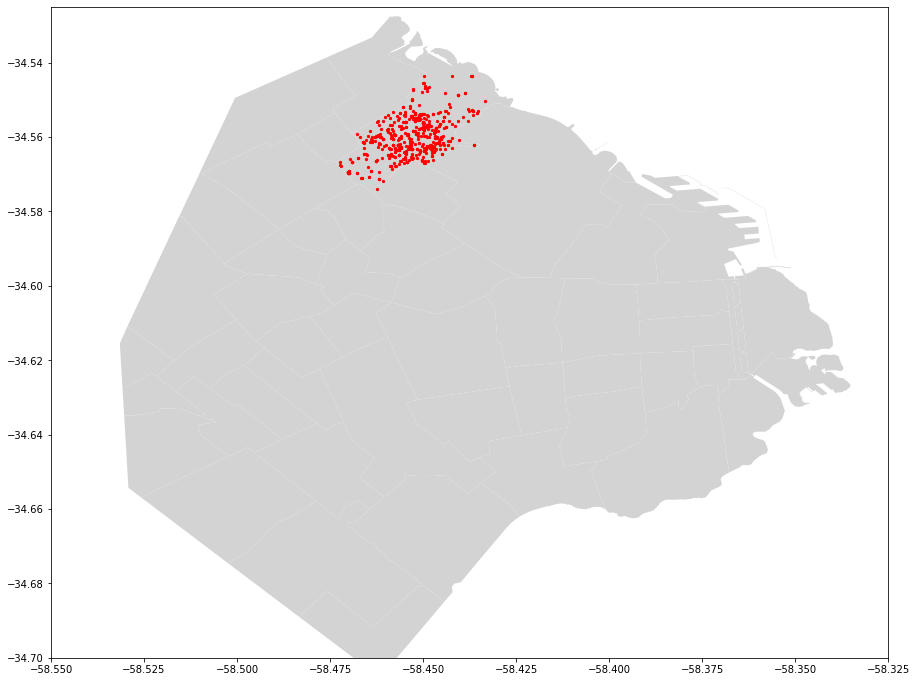

,search_longitude,search_latitude,timestamp,leave,arrive,search_method,uid,search_hour,arrive_hour,leave_hour,stay_time,arrive_weekday,geometry,reservas_barrio
23,-58.454943,-34.564354,2021-02-25 11:22:32,2021-02-25 12:20:09,2021-02-25 11:20:09,searchInThisArea,None,11.0,11,12,0 days 01:00:00,3,POINT (-58.45494 -34.56435),True
24,-58.451924,-34.559296,2020-09-17 05:13:03,2020-09-17 11:00:00,2020-09-17 10:45:00,update_time_home,unauthenticated,5.0,10,11,0 days 01:00:00,3,POINT (-58.45192 -34.55930),True
59,-58.459364,-34.564842,2021-02-20 21:54:12,2021-02-20 22:53:44,2021-02-20 21:53:44,searchInThisArea,i5Wh05mUiYTcQtvyUaQ2Xj7y9Al1,21.0,21,22,0 days 01:00:00,5,POINT (-58.45936 -34.56484),True
138,-58.449966,-34.556189,2020-10-19 14:38:44,2020-10-19 15:45:44,2020-10-19 14:45:44,startup,BLLbW2aUT4Xd5Kyu4lUX98MMget1,14.0,14,15,0 days 01:00:00,0,POINT (-58.44997 -34.55619),True
145,-58.457418,-34.567670,2021-03-10 05:48:53,2021-03-10 07:00:53,2021-03-10 06:00:53,startup,unauthenticated,5.0,6,7,0 days 01:00:00,2,POINT (-58.45742 -34.56767),True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20934,-58.464070,-34.569014,2021-02-27 13:11:31,2021-02-27 14:15:31,2021-02-27 13:15:31,startup,unauthenticated,13.0,13,14,0 days 01:00:00,5,POINT (-58.46407 -34.56901),True
20944,-58.456023,-34.562773,2021-03-25 09:16:37,2021-03-25 10:30:24,2021-03-25 09:30:24,google,unauthenticated,9.0,9,10,0 days 01:00:00,3,POINT (-58.45602 -34.56277),True
20948,-58.449675,-34.557740,2020-11-11 08:47:49,2020-11-11 10:00:17,2020-11-11 09:00:17,google,unauthenticated,8.0,9,10,0 days 01:00:00,2,POINT (-58.44967 -34.55774),True
20956,-58.449878,-34.557497,2021-02-13 14:28:17,2021-02-13 15:27:03,2021-02-13 14:27:03,searchInThisArea,e8itgepSU1YX6Q48HtrDpz76OXr1,14.0,14,15,0 days 01:00:00,5,POINT (-58.44988 -34.55750),True


In [8]:
belgrano = search_neighborhood(neighborhood = 'belgrano', coordinates=data)
belgrano

In [9]:
coordinates = data
neighborhood_list = ['chacarita',
"paternal",
'villa crespo',
'villa del parque',
'almagro',
'caballito',
'dique 3',
'villa santa rita',
'monte castro',
'villa real',
'flores',
'floresta',
'constitucion',
'belgrano',
'recoleta',
'retiro',
'san cristobal',
'boedo',
'velez sarsfield',
'villa luro',
'parque patricios',
'mataderos',
'villa lugano',
'escollera exterior',
'nuñez',
'boca',
'dique 2',
'san telmo',
'saavedra',
'coghlan',
'villa urquiza',
'colegiales',
'balvanera',
'dique 4',
'villa gral. mitre',
'dique 1',
'parque chas',
'agronomia',
'villa ortuzar',
'barracas',
'parque avellaneda',
'parque chacabuco',
'nueva pompeya',
'palermo',
'villa riachuelo',
'villa soldati',
'villa pueyrredon',
'villa devoto',
'liniers',
'versalles',
'puerto madero',
'monserrat',
'san nicolas'
    ]

list_upper = []

for i in neighborhood_list:
    neighbor = i.upper()
    list_upper.append(neighbor)    

gpd_dataframes_list = [] 

bsas_map = gpd.read_file('../gopa_data/barrios-ciudad')
bsas_map.BARRIO[6] = 'DIQUE 3'
bsas_map.BARRIO[24] = 'NUÑEZ'
bsas_map.BARRIO[26] = 'DIQUE 2'
bsas_map.BARRIO[33] = 'DIQUE 4'
bsas_map.BARRIO[35] = 'DIQUE 1' 

for neighbor in list_upper:
    gpd_data = gpd.GeoDataFrame(coordinates,
                     geometry = gpd.points_from_xy(coordinates.search_longitude, coordinates.search_latitude))

    polygon_neighbor = bsas_map[bsas_map['BARRIO'] == neighbor].geometry
    gpd_data ['neighbor'] = gpd_data.apply(lambda x: polygon_neighbor.contains(x.geometry), axis=1)
    gpd_data ['neighbor'] = gpd_data ['neighbor'].apply(lambda x: 0 if x == False else neighbor)
    gpd_data = gpd_data[gpd_data.neighbor != 0]
    gpd_dataframes_list.append(gpd_data)

all_data = pd.concat(gpd_dataframes_list)
    



<ipython-input-9-c7eb525d0cb9>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bsas_map.BARRIO[6] = 'DIQUE 3'
<ipython-input-9-c7eb525d0cb9>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bsas_map.BARRIO[24] = 'NUÑEZ'
<ipython-input-9-c7eb525d0cb9>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bsas_map.BARRIO[26] = 'DIQUE 2'
<ipython-input-9-c7eb525d0cb9>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [ ]:
all_data

In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
sns.countplot(y="neighbor", data=all_data, color="c")


In [ ]:
all_data.neighbor.value_counts()

In [ ]:
sns.histplot(data=all_data, x="arrive_hour", binwidth=1, kde=True)


In [ ]:
sns.histplot(data=all_data, x="search_hour", binwidth=1, kde=True)



In [ ]:
uid = pd.DataFrame(all_data.uid.value_counts())
uid.head(50)

In [ ]:
def adding_numbers(x):
    num = 0
    if x == None:
        x = num
        return x
        num = num + 1
    else:
        pass



In [ ]:
all_data


In [ ]:
weekday = pd.DataFrame(data=all_data.groupby("arrive_weekday").uid.count()).reset_index()
weekday

plt.figure(figsize=(10,6))

plt.plot(all_data["arrive_weekday"], all_data["uid"])
plt.xlabel("weekday\n (0:Monday ~ 6:Sunday)")
plt.ylabel("count")
plt.ylim([200000, 300000])

In [ ]:
sns.histplot(data=recoleta, x="search_hour", binwidth=1, kde=True)


In [ ]:
sns.histplot(data=data, x="arrive_hour", binwidth=1, kde=True)


In [ ]:
sns.histplot(data=data, x="arrive_weekday", binwidth=1, kde=True)


In [ ]:
sns.histplot(data=data, x="arrive_hour", hue="arrive_weekday")


In [ ]:
sns.histplot(data=data, x="arrive_hour", y="arrive_weekday", legend=True)

In [ ]:
caba = search_neighborhood(neighborhood = 'ciudad', coordinates=data)
ax = sns.regplot(x="arrive_hour", y="arrive", data=caba)